# Evaluación del modelo

Se presenta la fase final de evaluación e interpretabilidad del modelo de Regresión Logística seleccionado para la predicción de enfermedad cardíaca.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

In [4]:
# --- 1. Carga y Preparación de Datos
try:
    df = pd.read_csv("heart.csv")
except FileNotFoundError:
    url = "https://raw.githubusercontent.com/Dovallec/Heart_Failure_Analysis/master/data/heart.csv"
    df = pd.read_csv(url)

In [5]:
target_col = "HeartDisease"
X = df.drop(columns=[target_col])
y = df[target_col]

# Columnas categóricas
cat_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# División train/test (misma semilla y proporción que en el modelamiento)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensiones de entrenamiento: {X_train.shape}")
print(f"Dimensiones de prueba: {X_test.shape}")

Dimensiones de entrenamiento: (734, 15)
Dimensiones de prueba: (184, 15)


In [6]:
# --- 2. Entrenamiento del Modelo Final

# Hiperparámetros óptimos encontrados con GridSearchCV para Regresión Logística
best_params = {
    'C': 1.0,
    'class_weight': 'balanced',
    'max_iter': 100000,
    'penalty': 'l2',
    'solver': 'lbfgs',
    'random_state': 42 # Se incluye para reproducibilidad
}

# Inicializar y entrenar el modelo final
final_model = LogisticRegression(**best_params)
final_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=100000, random_state=42)

In [11]:
# --- 3. Evaluación
y_pred = final_model.predict(X_test)

print("\n" + "="*50)
print("     RESULTADOS DE EVALUACIÓN DEL MODELO FINAL")
print("="*50)

# a) Reporte de Clasificación (Métricas)
print("\n[A] Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Heart Disease (0)', 'Heart Disease (1)']))


     RESULTADOS DE EVALUACIÓN DEL MODELO FINAL

[A] Reporte de Clasificación:
                      precision    recall  f1-score   support

No Heart Disease (0)       0.91      0.84      0.87        82
   Heart Disease (1)       0.88      0.93      0.90       102

            accuracy                           0.89       184
           macro avg       0.89      0.89      0.89       184
        weighted avg       0.89      0.89      0.89       184



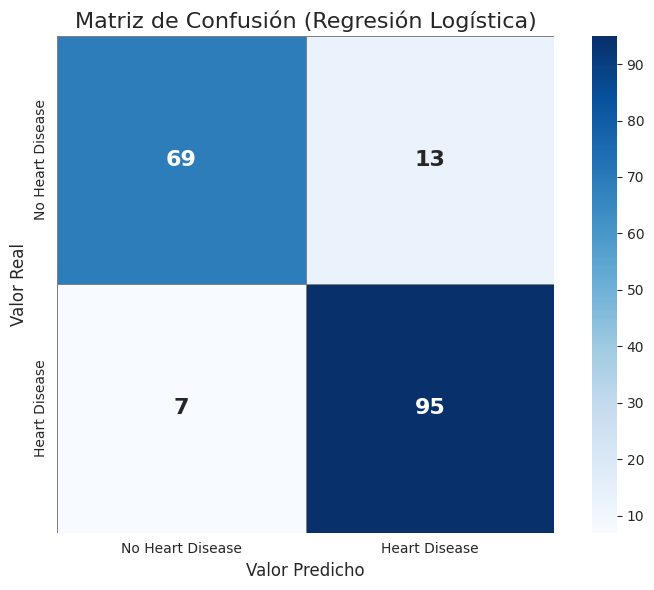

In [13]:
# b) Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
labels = ['No Heart Disease', 'Heart Disease']

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    annot_kws={'size': 16, 'weight': 'bold'}
)
plt.title('Matriz de Confusión (Regresión Logística)', fontsize=16)
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Predicho', fontsize=12)
plt.tight_layout()
plt.show()



Se confirma la robustez del modelo final (entrenado con parámetros óptimos) al generar métricas sobre el conjunto de prueba no visto. La matriz de confusión y el reporte de clasificación validan la Exactitud (Accuracy 0.89), destacando la alta Sensibilidad (Recall 0.93) para detectar la enfermedad, lo cual es crítico en la aplicación de screening médico (minimiza Falsos Negativos).

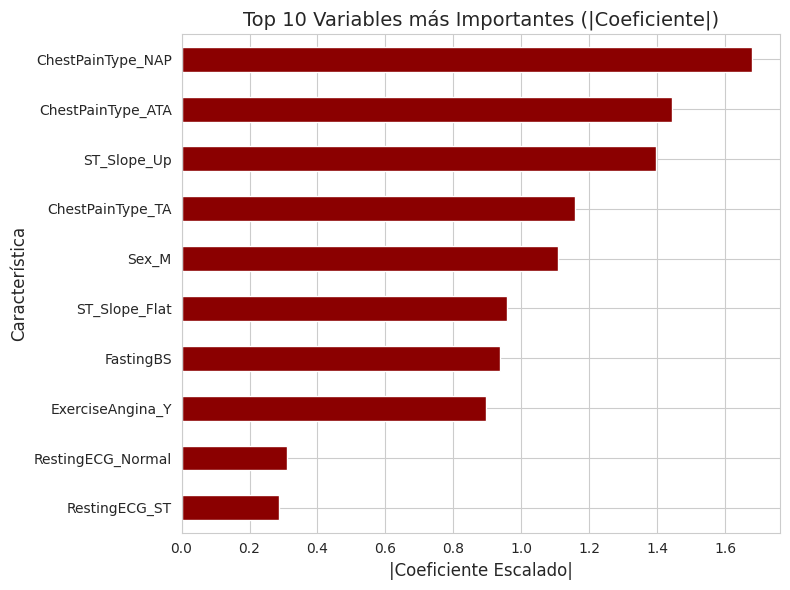


[C] Top 5 Coeficientes Positivos (Aumentan riesgo):
Sex_M               1.107773
ST_Slope_Flat       0.957785
FastingBS           0.937377
ExerciseAngina_Y    0.896396
Oldpeak             0.279112
dtype: float64

[D] Top 5 Coeficientes Negativos (Disminuyen riesgo):
ChestPainType_NAP   -1.676931
ChestPainType_ATA   -1.443854
ST_Slope_Up         -1.396435
ChestPainType_TA    -1.156222
RestingECG_Normal   -0.309653
dtype: float64


In [15]:
# c) Importancia de las Características (Interpretación)
# La Regresión Logística usa coeficientes para la importancia
coefs = pd.Series(final_model.coef_[0], index=X_train.columns)
coefs_abs = coefs.abs().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
coefs_abs.head(10).plot(kind="barh", color='darkred')
plt.title("Top 10 Variables más Importantes (|Coeficiente|)", fontsize=14)
plt.xlabel("|Coeficiente Escalado|", fontsize=12)
plt.ylabel("Característica", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n[C] Top 5 Coeficientes Positivos (Aumentan riesgo):")
print(coefs.sort_values(ascending=False).head(5))
print("\n[D] Top 5 Coeficientes Negativos (Disminuyen riesgo):")
print(coefs.sort_values(ascending=True).head(5))

Adicionalmente, se realiza un paso de interpretabilidad al visualizar los coeficientes de la Regresión Logística. Los coeficientes positivos como *ST_Slope_Flat, ExerciseAngina_Y*, indican las características que aumentan la probabilidad de enfermedad cardíaca, mientras que los coeficientes negativos como *ST_Slope_Up, MaxHR*, indican aquellas que la disminuyen. Esta interpretación no solo justifica las predicciones del modelo, sino que también correlaciona los hallazgos del machine learning con el conocimiento clínico (por ejemplo un ST_Slope_Up más alto generalmente es un hallazgo más saludable, reduciendo el riesgo).